In [2]:
import os
import torch
import torchvision
import tarfile
import time 
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [4]:
# Check if the target directory already contains the extracted files
if not os.path.exists('./data/cifar10'):
    # If not extracted, extract the files
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')
else:
    print("CIFAR-10 dataset already extracted.")

CIFAR-10 dataset already extracted.


In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [9]:
import random

img, label = dataset[random.randint(0, len(dataset))]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 7


tensor([[[0.5451, 0.5294, 0.5294,  ..., 0.5333, 0.5333, 0.5333],
         [0.5490, 0.5294, 0.5294,  ..., 0.5255, 0.5294, 0.5333],
         [0.5529, 0.5451, 0.5451,  ..., 0.5333, 0.5176, 0.5294],
         ...,
         [0.4196, 0.3922, 0.3569,  ..., 0.3961, 0.4157, 0.4471],
         [0.4392, 0.4157, 0.4039,  ..., 0.4353, 0.4235, 0.4314],
         [0.4706, 0.4431, 0.4510,  ..., 0.4392, 0.4353, 0.4314]],

        [[0.5294, 0.5176, 0.5176,  ..., 0.5176, 0.5176, 0.5216],
         [0.5373, 0.5176, 0.5176,  ..., 0.5098, 0.5137, 0.5216],
         [0.5412, 0.5333, 0.5333,  ..., 0.5176, 0.5020, 0.5176],
         ...,
         [0.4235, 0.3922, 0.3608,  ..., 0.3647, 0.3843, 0.4157],
         [0.4353, 0.4078, 0.3961,  ..., 0.4039, 0.3922, 0.4000],
         [0.4510, 0.4275, 0.4353,  ..., 0.4078, 0.4039, 0.4000]],

        [[0.5098, 0.4980, 0.4980,  ..., 0.5059, 0.5059, 0.5098],
         [0.5176, 0.4980, 0.4980,  ..., 0.4980, 0.5020, 0.5059],
         [0.5216, 0.5137, 0.5137,  ..., 0.5059, 0.4902, 0.

In [10]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


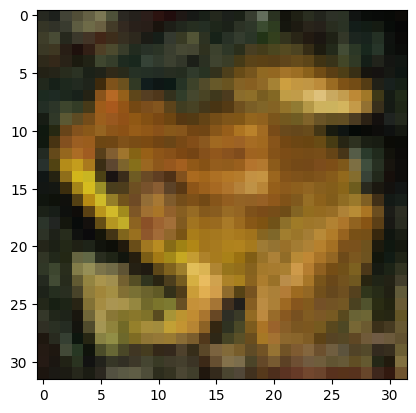

In [11]:
show_example(*dataset[random.randint(0, len(dataset))])

In [12]:
random_seed = 3407
torch.manual_seed(random_seed);

In [13]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

train_dl_cpu = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl_cpu = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

train_dl_gpu = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl_gpu = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

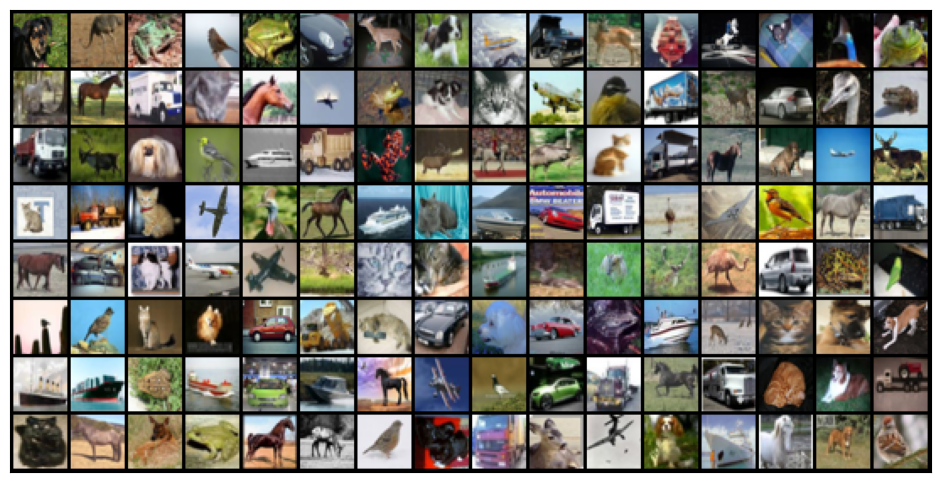

In [17]:
show_batch(train_dl)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [20]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [21]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def move_to_device(train_dl, val_dl, model, device):
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    model = to_device(model, device)
    return train_dl, val_dl, model

# TODO: notes about compaing CPU vs GPU (CUDA)

In [24]:
#Show available CUDA devices
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Available GPU devices:")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA available.")



Available GPU devices:
Device 0: NVIDIA GeForce RTX 2070 SUPER


In [25]:
# Common training parameters
num_epochs = 12
opt_func = torch.optim.Adam
lr = 0.001


In [26]:
# Use GPU (CUDA) for training if available
if torch.cuda.is_available():
    print("Training on GPU.")
    train_dl_gpu, val_dl_gpu, model_gpu = move_to_device(train_dl, val_dl, Cifar10CnnModel(), torch.device("cuda"))
    gpu_start_time = time.time()
    history_gpu = fit(num_epochs, lr, model_gpu, train_dl_gpu, val_dl_gpu, opt_func)
    gpu_end_time = time.time()
    print(f"GPU training took: {gpu_end_time - gpu_start_time} seconds.")

Training on GPU.
Epoch [0], train_loss: 1.7439, val_loss: 1.3792, val_acc: 0.4788
Epoch [1], train_loss: 1.2395, val_loss: 1.2045, val_acc: 0.5687
Epoch [2], train_loss: 0.9695, val_loss: 0.8950, val_acc: 0.6811
Epoch [3], train_loss: 0.7897, val_loss: 0.7749, val_acc: 0.7293
Epoch [4], train_loss: 0.6499, val_loss: 0.7521, val_acc: 0.7377
Epoch [5], train_loss: 0.5376, val_loss: 0.7330, val_acc: 0.7580
Epoch [6], train_loss: 0.4252, val_loss: 0.7205, val_acc: 0.7616
Epoch [7], train_loss: 0.3317, val_loss: 0.7977, val_acc: 0.7626
Epoch [8], train_loss: 0.2659, val_loss: 0.8299, val_acc: 0.7644
Epoch [9], train_loss: 0.2021, val_loss: 0.9495, val_acc: 0.7589
Epoch [10], train_loss: 0.1553, val_loss: 1.0070, val_acc: 0.7771
Epoch [11], train_loss: 0.1313, val_loss: 1.0326, val_acc: 0.7669
GPU training took: 334.38140535354614 seconds.


In [27]:
# Use CPU for training
print("Training on CPU.")
train_dl_cpu, val_dl_cpu, model_cpu = move_to_device(train_dl, val_dl, Cifar10CnnModel(), torch.device("cpu"))
cpu_start_time = time.time()
history_cpu = fit(num_epochs, lr, model_cpu, train_dl_cpu, val_dl_cpu, opt_func)
cpu_end_time = time.time()


Training on CPU.
Epoch [0], train_loss: 1.8196, val_loss: 1.4366, val_acc: 0.4609
Epoch [1], train_loss: 1.2972, val_loss: 1.1304, val_acc: 0.5834
Epoch [2], train_loss: 1.0093, val_loss: 0.9439, val_acc: 0.6657
Epoch [3], train_loss: 0.8199, val_loss: 0.8273, val_acc: 0.7104
Epoch [4], train_loss: 0.6790, val_loss: 0.7933, val_acc: 0.7303
Epoch [5], train_loss: 0.5479, val_loss: 0.7117, val_acc: 0.7503
Epoch [6], train_loss: 0.4356, val_loss: 0.7519, val_acc: 0.7540
Epoch [7], train_loss: 0.3295, val_loss: 0.8409, val_acc: 0.7485
Epoch [8], train_loss: 0.2446, val_loss: 0.8880, val_acc: 0.7471
Epoch [9], train_loss: 0.1723, val_loss: 1.0028, val_acc: 0.7498
Epoch [10], train_loss: 0.1368, val_loss: 1.1889, val_acc: 0.7497
Epoch [11], train_loss: 0.1164, val_loss: 1.2850, val_acc: 0.7473


In [28]:
print(f"CPU training took: {cpu_end_time - cpu_start_time} seconds.")
print(f"CUDA vs CPU training time comparison on CIFAR-10 dataset with {num_epochs} epoch(s):")
print(f"CPU training time: {cpu_end_time - cpu_start_time:.2f} seconds")
print(f"GPU training time: {gpu_end_time - gpu_start_time:.2f} seconds")
print(f"Speedup: {(cpu_end_time - cpu_start_time) / (gpu_end_time - gpu_start_time):.2f}x")
print("Difference: ", cpu_end_time - cpu_start_time - (gpu_end_time - gpu_start_time))


CPU training took: 5869.352095842361 seconds.
CUDA vs CPU training time comparison on CIFAR-10 dataset with 12 epoch(s):
CPU training time: 5869.35 seconds
GPU training time: 334.38 seconds
Speedup: 17.55x
Difference:  5534.970690488815


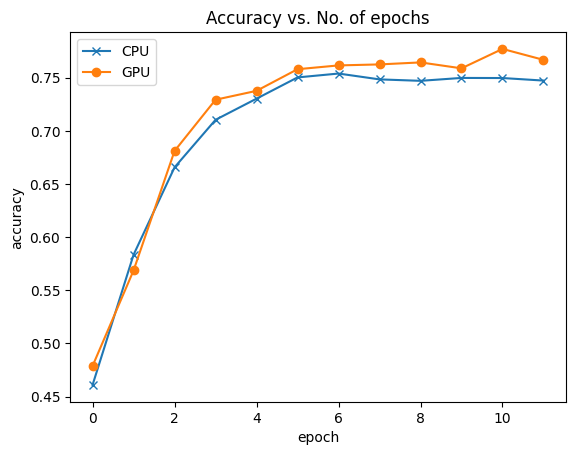

In [29]:

def plot_accuracies(history_cpu, history_gpu):
    accuracies_cpu = [x['val_acc'] for x in history_cpu]
    accuracies_gpu = [x['val_acc'] for x in history_gpu]
    plt.plot(accuracies_cpu, '-x', label='CPU')
    plt.plot(accuracies_gpu, '-o', label='GPU')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend();
#compare accuracies beetwen CPU and GPU
plot_accuracies(history_cpu,history_gpu)

# BADANIE MODELU

In [32]:
def train_on_gpu(train_dl, val_dl, model, lr, num_epochs, opt_func):
    if torch.cuda.is_available():
        train_dl_gpu, val_dl_gpu, model_gpu = move_to_device(train_dl, val_dl, model, torch.device("cuda"))
        gpu_start_time = time.time()
        history_gpu = fit(num_epochs, lr, model_gpu, train_dl_gpu, val_dl_gpu, opt_func)
        gpu_end_time = time.time()
        print(f"\tGPU training took: {gpu_end_time - gpu_start_time} seconds.\n")
        training_time = gpu_end_time - gpu_start_time
        return history_gpu,training_time,model_gpu

# print("CONTROL")
# history = train_on_gpu(train_dl, val_dl, Cifar10CnnModel(), 0.001, 1, torch.optim.Adam)

# Define the sets of parameters
lr_list = [0.0005, 0.001, 0.002]
num_epochs_list = [8,10,12]
opt_func_list = [torch.optim.Adam, torch.optim.NAdam, torch.optim.RAdam, torch.optim.AdamW, torch.optim.Adamax, torch.optim.RMSprop]



# Initialize a list to store the histories
all_histories = []
all_models = []

# Loop over all combinations of parameters
for lr in lr_list:
    for num_epochs in num_epochs_list:
        for opt_func in opt_func_list:
            torch.cuda.empty_cache()
            print(f"Training with lr={lr}, num_epochs={num_epochs}, opt_func={opt_func.__name__}")
            history, training_time, model = train_on_gpu(train_dl, val_dl, Cifar10CnnModel(), lr, num_epochs, opt_func)
            # Add the used parameters to the history
            history[-1]['lr'] = lr
            history[-1]['num_epochs'] = num_epochs
            history[-1]['opt_func'] = opt_func.__name__
            history[-1]['time'] = training_time  # Add the training time to the history
            all_histories.append(history)
            all_models.append(model)
            # Save the model to a file
            try:
                torch.save(model.state_dict(), f'./models/model_lr-{lr}_epochs-{num_epochs}_optfunc-{opt_func.__name__}.pth')
            except IOError as e:
                print(f"Error saving model: {e}")

# Print the memory location of each model
# for i, model in enumerate(all_models):
#     print(f"Model {i}: {id(model)}")


Training with lr=0.0005, num_epochs=8, opt_func=Adam
Epoch [0], train_loss: 1.7862, val_loss: 1.4262, val_acc: 0.4813
Epoch [1], train_loss: 1.2975, val_loss: 1.1380, val_acc: 0.5883
Epoch [2], train_loss: 1.0554, val_loss: 0.9517, val_acc: 0.6545
Epoch [3], train_loss: 0.8775, val_loss: 0.8713, val_acc: 0.6892
Epoch [4], train_loss: 0.7557, val_loss: 0.8073, val_acc: 0.7235
Epoch [5], train_loss: 0.6501, val_loss: 0.7557, val_acc: 0.7418
Epoch [6], train_loss: 0.5491, val_loss: 0.6948, val_acc: 0.7638
Epoch [7], train_loss: 0.4654, val_loss: 0.6649, val_acc: 0.7714
	GPU training took: 212.66150522232056 seconds.

Training with lr=0.0005, num_epochs=8, opt_func=NAdam
Epoch [0], train_loss: 1.7919, val_loss: 1.4906, val_acc: 0.4454
Epoch [1], train_loss: 1.2441, val_loss: 1.1995, val_acc: 0.5544
Epoch [2], train_loss: 0.9396, val_loss: 0.8977, val_acc: 0.6810
Epoch [3], train_loss: 0.7371, val_loss: 0.7570, val_acc: 0.7335
Epoch [4], train_loss: 0.5799, val_loss: 0.7405, val_acc: 0.7475

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000015C7E1932E0>
Traceback (most recent call last):
  File "c:\Users\eryks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\eryks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch [3], train_loss: 1.0713, val_loss: 1.0119, val_acc: 0.6377
Epoch [4], train_loss: 0.9189, val_loss: 0.9461, val_acc: 0.6710
Epoch [5], train_loss: 0.8010, val_loss: 0.7727, val_acc: 0.7308
Epoch [6], train_loss: 0.6655, val_loss: 0.7239, val_acc: 0.7488
Epoch [7], train_loss: 0.5569, val_loss: 0.6776, val_acc: 0.7721
	GPU training took: 210.2969150543213 seconds.

Training with lr=0.0005, num_epochs=8, opt_func=AdamW
Epoch [0], train_loss: 1.7543, val_loss: 1.5365, val_acc: 0.4281
Epoch [1], train_loss: 1.2869, val_loss: 1.1401, val_acc: 0.5866
Epoch [2], train_loss: 1.0205, val_loss: 0.9931, val_acc: 0.6496
Epoch [3], train_loss: 0.8399, val_loss: 0.8318, val_acc: 0.7073
Epoch [4], train_loss: 0.6938, val_loss: 0.7314, val_acc: 0.7377
Epoch [5], train_loss: 0.5778, val_loss: 0.7138, val_acc: 0.7552
Epoch [6], train_loss: 0.4703, val_loss: 0.6767, val_acc: 0.7707
Epoch [7], train_loss: 0.3641, val_loss: 0.7115, val_acc: 0.7741
	GPU training took: 231.5498502254486 seconds.

Train

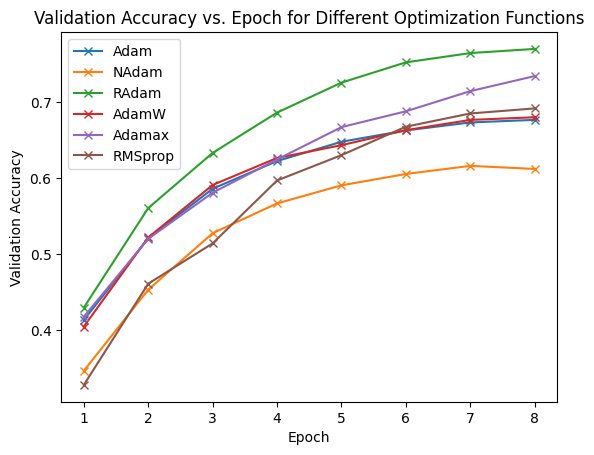

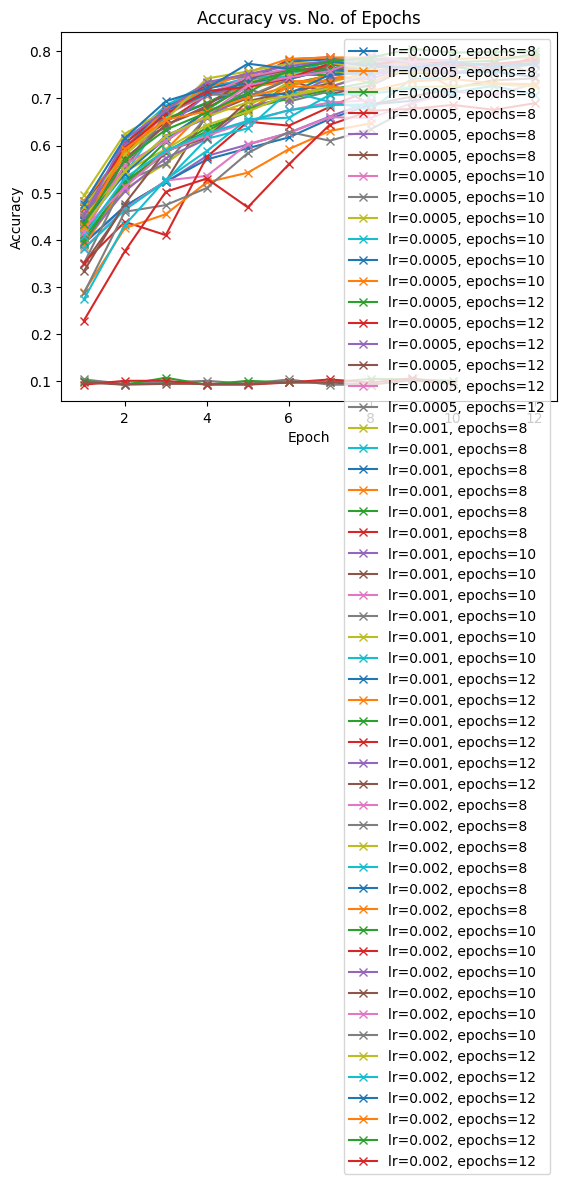

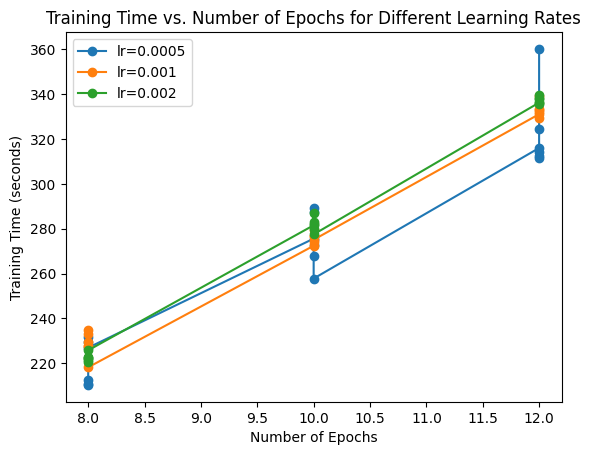

In [33]:
def plot_accuracies(histories):
    for history in histories:
        accuracies = [epoch['val_acc'] for epoch in history]
        lr = history[-1]['lr']  # Accessing lr from the last dictionary in the history list
        epochs = len(history)
        plt.plot(range(1, epochs + 1), accuracies, '-x', label=f'lr={lr}, epochs={epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    plt.legend()
    plt.show()

def plot_training_times(histories):
    lr_epochs_times = {}
    for history in histories:
        lr = history[-1]['lr']  # Accessing lr from the last dictionary in the history list
        epochs = len(history)
        time_taken = history[-1]['time']
        if lr not in lr_epochs_times:
            lr_epochs_times[lr] = []
        lr_epochs_times[lr].append((epochs, time_taken))
    for lr, epochs_times in lr_epochs_times.items():
        epochs_times.sort(key=lambda x: x[0])  # Sort by number of epochs
        epochs, times = zip(*epochs_times)
        plt.plot(epochs, times, '-o', label=f'lr={lr}')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Epochs for Different Learning Rates')
    plt.legend()
    plt.show()

def plot_optimization_functions(histories):
    opt_func_accuracies = {}
    for history in histories:
        opt_func = history[-1]['opt_func']  # Accessing opt_func from the last dictionary in the history list
        accuracies = [epoch['val_acc'] for epoch in history]
        if opt_func not in opt_func_accuracies:
            opt_func_accuracies[opt_func] = []
        opt_func_accuracies[opt_func].append(accuracies)
    
    for opt_func, acc_list in opt_func_accuracies.items():
        avg_accuracies = [sum(acc[i] for acc in acc_list) / len(acc_list) for i in range(len(acc_list[0]))]
        plt.plot(range(1, len(avg_accuracies) + 1), avg_accuracies, '-x', label=f'{opt_func}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epoch for Different Optimization Functions')
    plt.legend()
    plt.show()

# Example usage:
# Assuming all_histories contains the list of histories obtained from training
plot_optimization_functions(all_histories)

# Plot the histories
plot_accuracies(all_histories)
plot_training_times(all_histories)


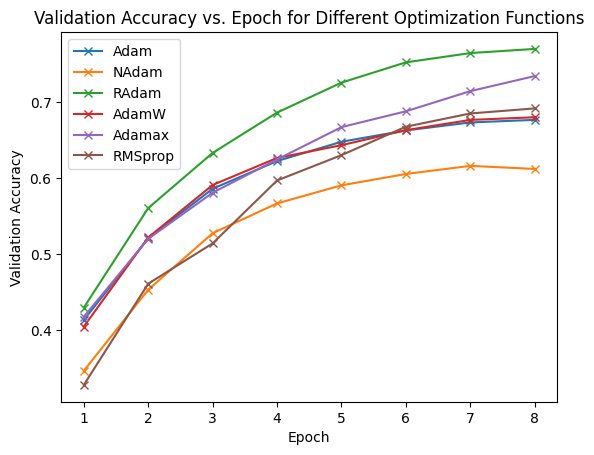

In [34]:
plot_optimization_functions(all_histories)

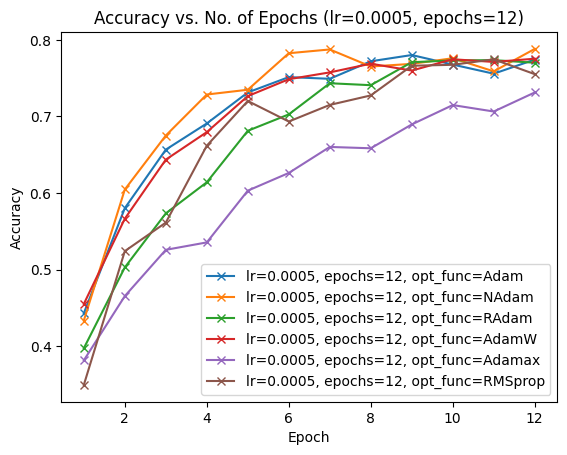

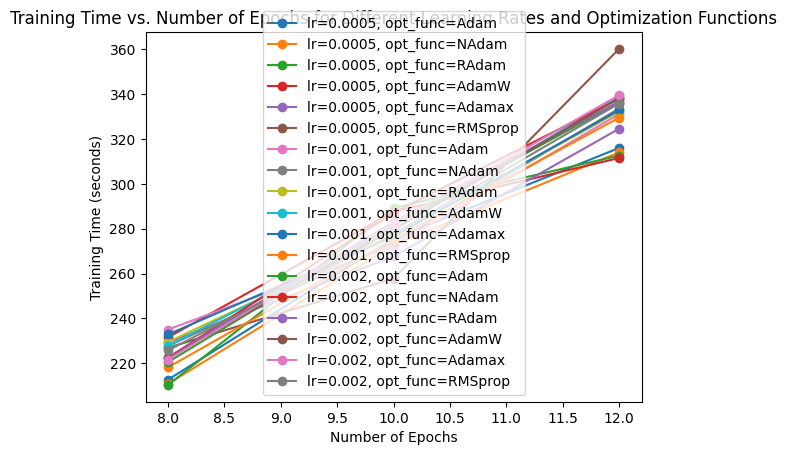

In [38]:
def plot_accuracies(histories, lr, num_epochs):
    filtered_histories = [history for history in histories if history[-1]['lr'] == lr and history[-1]['num_epochs'] == num_epochs]
    for history in filtered_histories:
        accuracies = [epoch['val_acc'] for epoch in history]
        epochs = len(history)
        opt_func = history[-1]['opt_func']  # Accessing opt_func from the last dictionary in the history list
        plt.plot(range(1, epochs + 1), accuracies, '-x', label=f'lr={lr}, epochs={epochs}, opt_func={opt_func}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. No. of Epochs (lr={lr}, epochs={num_epochs})')
    plt.legend()
    plt.show()

def plot_training_times(histories):
    lr_epochs_times = {}
    for history in histories:
        lr = history[-1]['lr']  # Accessing lr from the last dictionary in the history list
        epochs = len(history)
        time_taken = history[-1]['time']
        opt_func = history[-1]['opt_func']  # Accessing opt_func from the last dictionary in the history list
        if (lr, opt_func) not in lr_epochs_times:
            lr_epochs_times[(lr, opt_func)] = []
        lr_epochs_times[(lr, opt_func)].append((epochs, time_taken))
    for (lr, opt_func), epochs_times in lr_epochs_times.items():
        epochs_times.sort(key=lambda x: x[0])  # Sort by number of epochs
        epochs, times = zip(*epochs_times)
        plt.plot(epochs, times, '-o', label=f'lr={lr}, opt_func={opt_func}')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Epochs for Different Learning Rates and Optimization Functions')
    plt.legend()
    plt.show()

# Plot the histories
plot_accuracies(all_histories,0.0005,12)
plot_training_times(all_histories)

In [41]:
best_metric = 0  # Initialize the best metric value
best_model = None  # Initialize the best model
best_history = None  # Initialize the history of the best model

# Loop over all histories to evaluate each model
for history in all_histories:
    # Extract the final epoch statistics from the history
    final_epoch_stats = history[-1]

    # Extract the validation accuracy from the final epoch statistics
    val_accuracy = final_epoch_stats['val_acc']

    # Check if this model has the best accuracy so far
    if val_accuracy > best_metric:
        best_metric = val_accuracy
        best_model_index = all_histories.index(history)  # Index of the best model
        best_model = all_models[best_model_index]
        best_history = final_epoch_stats

# Print the information of the best model
print(f"Best model achieved validation accuracy: {best_metric}")
print(f"Parameters of the best model:")
print(f"Learning rate: {best_history['lr']}")
print(f"Number of epochs: {best_history['num_epochs']}")
print(f"Optimization function: {best_history['opt_func']}")
print(f"Training time: {best_history['time']} seconds")

# Save the best model to a file
try:
    torch.save(best_model.state_dict(), './models/best_model.pth')
except IOError as e:
    print(f"Error saving best model: {e}")


Best model achieved validation accuracy: 0.80078125
Parameters of the best model:
Learning rate: 0.002
Number of epochs: 12
Optimization function: Adamax
Training time: 339.56767773628235 seconds


In [ ]:
#odpierdaanie modelui



# OLD

In [ ]:
all_histories = []
models_table = []

num_epochs_list = [10]
lr_list = [0.01]
variations = len(num_epochs_list) * len(lr_list)
print(f"Training {variations} models with different combinations of num_epochs and lr.")

train_dl_gpu = [None]*variations
val_dl_gpu = [None]*variations
model_gpu = [None]*variations

# Train models
for i in range(variations):
    for num_epochs in num_epochs_list:
        for lr in lr_list:
            if torch.cuda.is_available():
                train_dl_gpu[i], val_dl_gpu[i], model_gpu[i] = move_to_device(train_dl, val_dl, Cifar10CnnModel(), torch.device("cuda"))
                print(f"Training on GPU with num_epochs={num_epochs} and lr={lr}.")
                gpu_start_time = time.time()
                history = fit(num_epochs, lr, model_gpu[i], train_dl_gpu[i], val_dl_gpu[i])
                gpu_end_time = time.time()
                print(f"GPU training took: {gpu_end_time - gpu_start_time} seconds.\n")
                history[-1]['time'] = gpu_end_time - gpu_start_time  
                history[-1]['lr'] = lr  
                all_histories.append(history)
                models_table.append({'num_epochs': num_epochs, 'lr': lr, 'model': model_gpu[i]})

Training 1 models with different combinations of num_epochs and lr.
Training on GPU with num_epochs=10 and lr=0.01.


KeyboardInterrupt: 

In [ ]:
#empty cache
torch.cuda.empty_cache()
torch.xpu.empty_cache()


STARE PODEJSCIE

#in the next part will be used bcs of the GPU speed

In [ ]:
def plot_accuracies(histories):
    for history in histories:
        accuracies = [epoch['val_acc'] for epoch in history]
        lr = history[-1]['lr']  # Accessing lr from the last dictionary in the history list
        epochs = len(history)
        plt.plot(range(1, epochs + 1), accuracies, '-x', label=f'lr={lr}, epochs={epochs}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of Epochs')
    plt.legend()
    plt.show()

def plot_training_times(histories):
    lr_epochs_times = {}
    for history in histories:
        lr = history[-1]['lr']  # Accessing lr from the last dictionary in the history list
        epochs = len(history)
        time_taken = history[-1]['time']
        if lr not in lr_epochs_times:
            lr_epochs_times[lr] = []
        lr_epochs_times[lr].append((epochs, time_taken))
    for lr, epochs_times in lr_epochs_times.items():
        epochs_times.sort(key=lambda x: x[0])  # Sort by number of epochs
        epochs, times = zip(*epochs_times)
        plt.plot(epochs, times, '-o', label=f'lr={lr}')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Epochs for Different Learning Rates')
    plt.legend()
    plt.show()


In [ ]:
if torch.cuda.is_available():
    print("Training on GPU.")
    train_dl_gpu, val_dl_gpu, model_gpu = move_to_device(train_dl, val_dl, Cifar10CnnModel(), torch.device("cuda"))
    gpu_start_time = time.time()
    history_eh = fit(num_epochs, lr, model_gpu, train_dl_gpu, val_dl_gpu, opt_func)
    gpu_end_time = time.time()
    print(f"GPU training took: {gpu_end_time - gpu_start_time} seconds.")

Training on GPU.
Epoch [0], train_loss: 4.2660, val_loss: 2.3045, val_acc: 0.1002


KeyboardInterrupt: 

In [ ]:
all_histories = []
models_table = []

num_epochs_list = [10]
lr_list = [0.01]
variations = len(num_epochs_list) * len(lr_list)
print(f"Training {variations} models with different combinations of num_epochs and lr.")

train_dl_gpu = [None]*variations
val_dl_gpu = [None]*variations
model_gpu = [None]*variations

# Train models
for i in range(variations):
    for num_epochs in num_epochs_list:
        for lr in lr_list:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.xpu.empty_cache()
                train_dl_gpu[i], val_dl_gpu[i], model_gpu[i] = move_to_device(train_dl, val_dl, Cifar10CnnModel(), torch.device("cuda"))
                print(f"Training on GPU with num_epochs={num_epochs} and lr={lr}.")
                gpu_start_time = time.time()
                history = fit(num_epochs, lr, model_gpu[i], train_dl_gpu[i], val_dl_gpu[i])
                gpu_end_time = time.time()
                print(f"GPU training took: {gpu_end_time - gpu_start_time} seconds.\n")
                history[-1]['time'] = gpu_end_time - gpu_start_time  
                history[-1]['lr'] = lr  
                all_histories.append(history)
                models_table.append({'num_epochs': num_epochs, 'lr': lr, 'model': model_gpu[i]})

Training 1 models with different combinations of num_epochs and lr.
Epoch [0], train_loss: 7.9626, val_loss: 2.3031, val_acc: 0.0937


KeyboardInterrupt: 

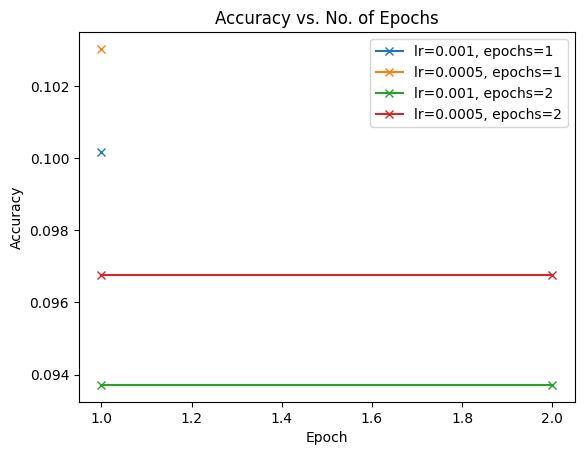

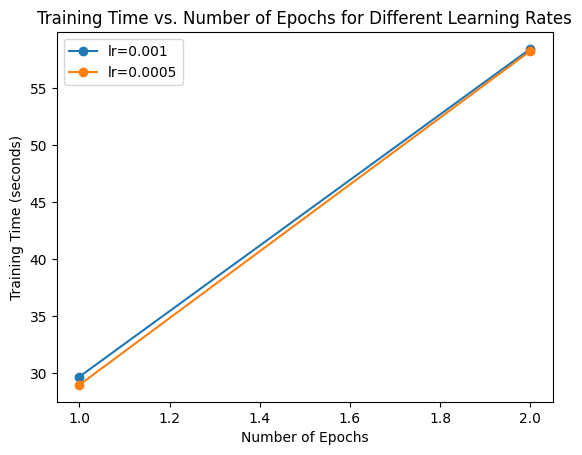

In [ ]:
# Plot all accuracies
plot_accuracies(all_histories)

# Plot training times
plot_training_times(all_histories)


In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
# Define your test_loader
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), torch.device("cuda"))

In [ ]:
# Function to find the trained model from the models_table
def find_trained_model(num_epochs, lr):
    for model_details in models_table:
        if model_details['num_epochs'] == num_epochs and model_details['lr'] == lr:
            return Cifar10CnnModel()  # Return a new instance of the model class
    return None  # Return None if model not found

# Iterate through all_histories to evaluate each trained model
for history in all_histories:
    num_epochs = len(history)
    lr = history[-1]['lr']
    # Find the model from models_table
    model = find_trained_model(num_epochs, lr)
    if model is not None:
        # Load the model to GPU
        model_gpu = model.to(torch.device("cuda"))
        # Evaluate the model
        result = evaluate(model_gpu, test_loader)
        print(f"Results for model with num_epochs={num_epochs} and lr={lr}: {result}")
    else:
        print(f"Model with num_epochs={num_epochs} and lr={lr} not found in models_table.")


Results for model with num_epochs=1 and lr=0.001: {'val_loss': 2.302446126937866, 'val_acc': 0.09765625}
Results for model with num_epochs=1 and lr=0.0005: {'val_loss': 2.30293345451355, 'val_acc': 0.09765625}
Results for model with num_epochs=2 and lr=0.001: {'val_loss': 2.3021934032440186, 'val_acc': 0.09765625}
Results for model with num_epochs=2 and lr=0.0005: {'val_loss': 2.3036091327667236, 'val_acc': 0.09765625}


# to edytuje na biezaco

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000281D5920040>
Traceback (most recent call last):
  File "c:\Users\eryks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\eryks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: bird


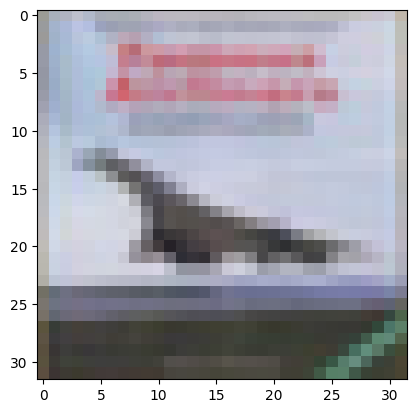

Label: airplane , Predicted: bird


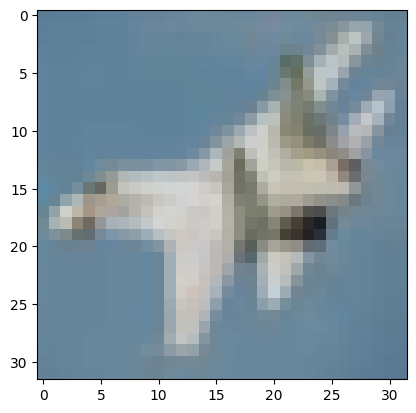

Label: airplane , Predicted: bird


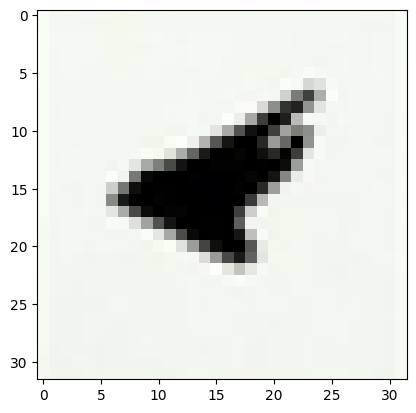

Label: airplane , Predicted: bird


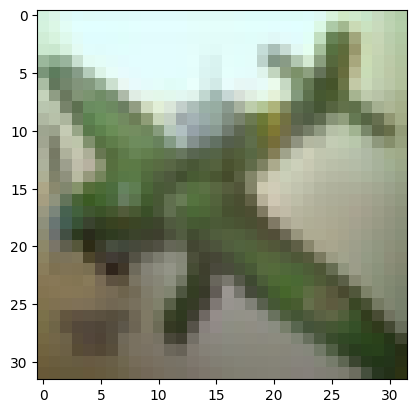

Label: airplane , Predicted: bird


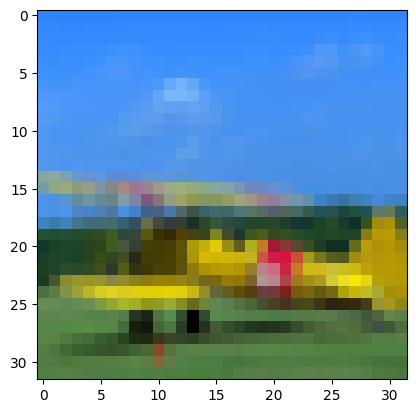

In [ ]:
for i in range(5):
    img, label = test_dataset[i]
    plt.imshow(img.permute(1, 2, 0))
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
    plt.show()

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), torch.device("cuda"))
result = evaluate(model_gpu, test_loader)
result

{'val_loss': 2.302295684814453, 'val_acc': 0.09765625}